In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandas as pd
from scipy.special import logit, expit

In [2]:
import KECENI

In [3]:
from true_model import *

# save directory and random seed

In [4]:
save_dir = 'data'

In [5]:
np.random.seed(12345)

# parameters

In [6]:
n_sim = 40
n_node = 4000
d_latent = 2

# latent position and network

In [7]:
Zs = np.random.uniform(-2, 2, (n_node, d_latent))

In [8]:
Zs, Zs.shape

(array([[ 1.71846437, -0.73449778],
        [-1.26432475, -1.18175889],
        [ 0.27090012,  0.38217881],
        ...,
        [-0.49773864,  0.89424208],
        [-1.76833337, -1.62887432],
        [ 0.75789336, -0.64000873]]),
 (4000, 2))

(array([ 584730., 1502148., 2078536., 2367026., 2411802., 2311884.,
        1992252., 1526526.,  924916.,  300180.]),
 array([0.        , 0.39994626, 0.79989252, 1.19983879, 1.59978505,
        1.99973131, 2.39967757, 2.79962383, 3.1995701 , 3.59951636,
        3.99946262]),
 <BarContainer object of 10 artists>)

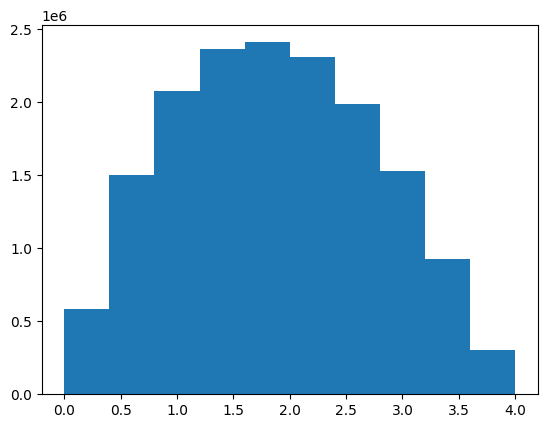

In [9]:
plt.hist(np.max(np.abs(Zs[:,None,:] - Zs[None,:,:]), -1).flatten())

In [10]:
# P = np.exp(-2-80*np.max(np.abs(Zs[:,None,:] - Zs[None,:,:])**2, axis=-1))
P = np.exp(- np.exp(12*np.max(np.abs(Zs[:,None,:] - Zs[None,:,:]), axis=-1)))
# P = np.max(np.abs(Zs[:,None,:] - Zs[None,:,:]), -1) < 0.05

In [11]:
P, P.shape

(array([[3.67879441e-001, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 3.67879441e-001, 0.00000000e+000, ...,
         0.00000000e+000, 1.44228344e-184, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 3.67879441e-001, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        ...,
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         3.67879441e-001, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 1.44228344e-184, 0.00000000e+000, ...,
         0.00000000e+000, 3.67879441e-001, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 3.67879441e-001]]),
 (4000, 4000))

In [12]:
ths = np.random.random((n_node, n_node))

In [13]:
rho = 1

In [14]:
Adj = (ths <= rho * P).astype(int)
Adj[np.arange(n_node), np.arange(n_node)] = 0
Adj = np.logical_or(Adj, Adj.T)

In [15]:
# Adj = np.random.binomial(1, P, (n_node, n_node))
# Adj[np.arange(n_node), np.arange(n_node)] = 0
# Adj = np.logical_or(Adj, Adj.T)

In [16]:
degree = np.sum(Adj, 0)

(array([ 342.,  806., 1032.,  886.,  527.,  242.,  108.,   36.,   14.,
           6.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <BarContainer object of 10 artists>)

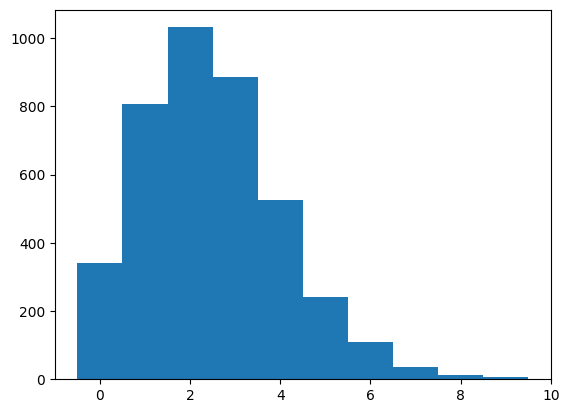

In [17]:
plt.hist(degree, np.arange(np.max(degree)+1)-0.5)

In [18]:
id_cntr = np.argmin(np.max(np.abs(Zs), -1)); id_cntr

2270

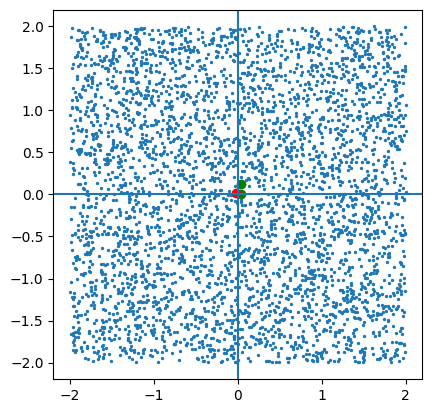

In [19]:
plt.gca().set_aspect('equal')
plt.scatter(*Zs.T, s=2)
plt.scatter(*Zs[Adj[id_cntr]==1].T, color='green')
plt.scatter(*Zs[id_cntr], color='red')
plt.axhline(y=0); plt.axvline(x=0)

In [20]:
G = KECENI.Graph(Adj, Zs)

In [21]:
row, col = np.where(Adj != 0)

Text(0, 0.5, '$Z_{i2}$')

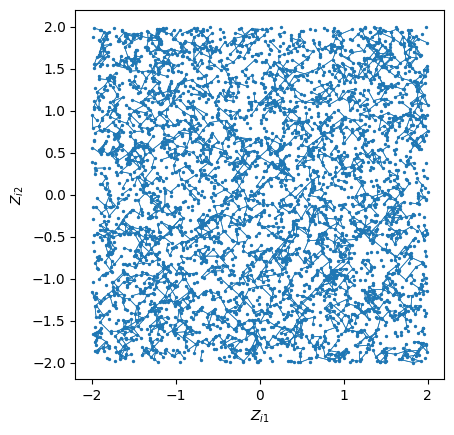

In [22]:
plt.gca().set_aspect('equal')
plt.scatter(*Zs.T, s=2)

for i, (r,c) in enumerate(zip(row, col)):
    plt.plot(*Zs[[r,c]].T, color='C0', linewidth=0.5)
    
plt.xlabel(r'$Z_{i1}$'); plt.ylabel(r'$Z_{i2}$')

In [23]:
data_latent = pd.DataFrame({'Z1': Zs[:,0], 'Z2': Zs[:,1]})
data_network = pd.DataFrame({'row': row+1, 'col': col+1})

In [24]:
data_latent.to_feather('%s/latent.feather'%save_dir)
data_network.to_feather('%s/network.feather'%save_dir)

# features

In [25]:
for i_sim in np.arange(n_sim):
    Xs = rX(1, np.arange(n_node), G)[0]
    
    Ws = rW(Xs)
    
    ps = np.array([
        pij(1, Xs[G.N1(i)], G.sub(G.N1(i))) 
        for i in np.arange(n_node)
    ])
    
    Ts = np.random.binomial(1, ps) 
    
    ms = np.array([
        mu(Ts[G.N1(i)], Xs[G.N2(i)], G.sub(G.N2(i))) 
        for i in np.arange(n_node)
    ])
    
    Ys = np.random.binomial(1, ms)
    
    data_feature = pd.DataFrame({
        'X1': Xs[:,0], 'X2': Xs[:,1], 'X3': Xs[:,2],  
        'W1': Ws[:,0], 'W2': Ws[:,1], 'W3': Ws[:,2], 
        'p': ps, 'T': Ts, 'm': ms, 'Y': Ys
    })
    
    data_feature.to_feather(
        '%s/feature_%.3d.feather'%(save_dir, i_sim)
    )

# check

In [26]:
i_sim = 0

In [27]:
data_feature = pd.read_feather(
    '%s/feature_%.3d.feather'%(save_dir, i_sim)
)

In [28]:
data_feature

,X1,X2,X3,W1,W2,W3,p,T,m,Y
0,0,1,1,-0.25,0.25,-0.25,0.500000,1,0.622459,0
1,0,0,1,0.25,-0.25,-0.25,0.222700,1,0.904651,1
2,1,0,0,-0.25,0.25,-0.25,0.544525,0,0.320821,1
3,0,1,1,-0.25,0.25,-0.25,0.651355,1,0.407333,1
4,1,1,1,0.25,0.25,0.25,0.500000,1,0.622459,1
...,...,...,...,...,...,...,...,...,...,...
3995,0,1,0,-0.25,-0.25,0.25,0.500000,1,0.622459,0
3996,1,1,0,0.25,-0.25,-0.25,0.500000,0,0.377541,0
3997,0,1,0,-0.25,-0.25,0.25,0.222700,0,0.777300,1
3998,0,0,0,0.25,0.25,0.25,0.777300,1,0.222700,0


In [29]:
#T, T_N1, X1, X2, X1_N1, X2_N2, W, W_N1

In [30]:
data_feature['X1_N1'] = np.array([
    summary_mu(
        data_feature['T'].values[G.N1(i)], 
        data_feature[np.array(['X1','X2','X3'])].values[G.N2(i)], G.sub(G.N2(i)))
    for i in np.arange(n_node)
])[:,-6]
data_feature['X2_N1'] = np.array([
    summary_mu(
        data_feature['T'].values[G.N1(i)], 
        data_feature[np.array(['X1','X2','X3'])].values[G.N2(i)], G.sub(G.N2(i)))
    for i in np.arange(n_node)
])[:,-5]
data_feature['X3_N1'] = np.array([
    summary_mu(
        data_feature['T'].values[G.N1(i)], 
        data_feature[np.array(['X1','X2','X3'])].values[G.N2(i)], G.sub(G.N2(i)))
    for i in np.arange(n_node)
])[:,-4]

In [31]:
data_feature['W1_N1'] = np.array([
    summary_mu(
        data_feature['T'].values[G.N1(i)], 
        data_feature[np.array(['X1','X2','X3'])].values[G.N2(i)], G.sub(G.N2(i)))
    for i in np.arange(n_node)
])[:,-3]
data_feature['W2_N1'] = np.array([
    summary_mu(
        data_feature['T'].values[G.N1(i)], 
        data_feature[np.array(['X1','X2','X3'])].values[G.N2(i)], G.sub(G.N2(i)))
    for i in np.arange(n_node)
])[:,-2]
data_feature['W3_N1'] = np.array([
    summary_mu(
        data_feature['T'].values[G.N1(i)], 
        data_feature[np.array(['X1','X2','X3'])].values[G.N2(i)], G.sub(G.N2(i)))
    for i in np.arange(n_node)
])[:,-1]

In [32]:
# Ws_N1 = np.array([
#     regressor_pi(Xs[G.N1(i)], G.sub(G.N1(i)))
#     for i in np.arange(n_node)
# ])[:,-1]

(array([1966.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2034.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

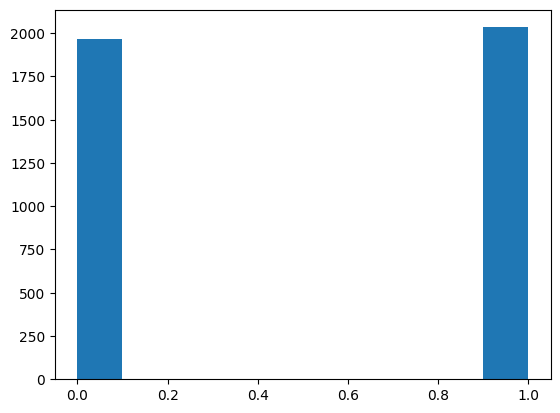

In [33]:
plt.hist(data_feature['X1'])

(array([2022.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1978.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

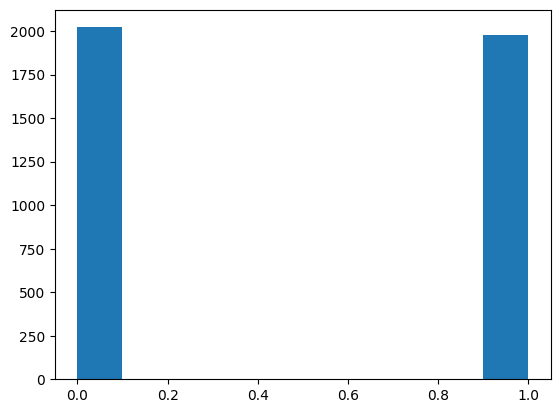

In [34]:
plt.hist(data_feature['X2'])

(array([ 808.,   49.,  116.,  410.,    8., 1113.,  473.,  149.,   52.,
         822.]),
 array([0.22270014, 0.27816011, 0.33362008, 0.38908006, 0.44454003,
        0.5       , 0.55545997, 0.61091994, 0.66637992, 0.72183989,
        0.77729986]),
 <BarContainer object of 10 artists>)

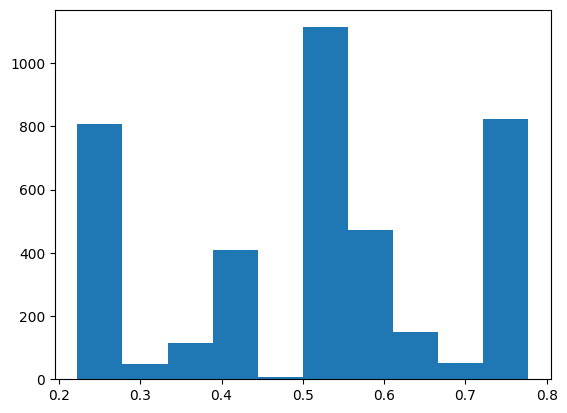

In [35]:
plt.hist(data_feature['p'])

(array([168.,  10.,  45., 149.,   4., 560., 277.,  95.,  36., 651.]),
 array([0.22270014, 0.27816011, 0.33362008, 0.38908006, 0.44454003,
        0.5       , 0.55545997, 0.61091994, 0.66637992, 0.72183989,
        0.77729986]),
 <BarContainer object of 10 artists>)

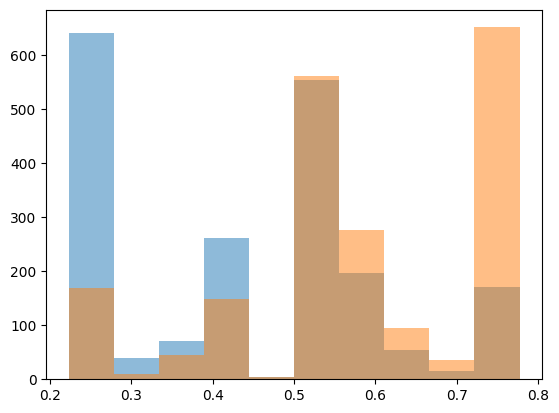

In [36]:
plt.hist((data_feature.query('T == 0')['p']), alpha=0.5)
plt.hist((data_feature.query('T == 1')['p']), alpha=0.5)

In [37]:
np.mean(data_feature.query('T == 0')['p'])

0.42848102341264493

In [38]:
np.mean(data_feature.query('T == 1')['p'])

0.5795577130456137

In [39]:
np.mean(data_feature['T'])

0.49875

(array([2009.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1991.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

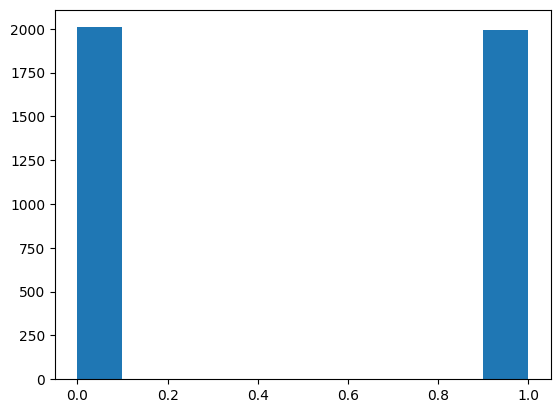

In [40]:
plt.hist(data_feature['Y'])

(array([651.,   8., 120., 231.,  53., 556.,   4., 149.,  53., 170.]),
 array([0.22270014, 0.29089518, 0.35909022, 0.42728526, 0.4954803 ,
        0.56367534, 0.63187038, 0.70006542, 0.76826046, 0.8364555 ,
        0.90465054]),
 <BarContainer object of 10 artists>)

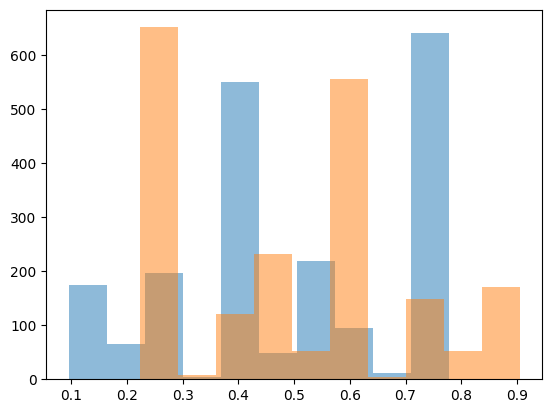

In [41]:
plt.hist(data_feature.query('T == 0')['m'], alpha=0.5)
plt.hist(data_feature.query('T == 1')['m'], alpha=0.5)

(array([1015.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         980.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

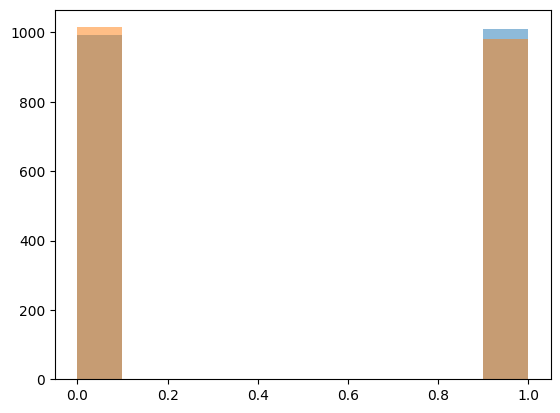

In [42]:
plt.hist(data_feature.query('T == 0')['Y'], alpha=0.5)
plt.hist(data_feature.query('T == 1')['Y'], alpha=0.5)

In [43]:
np.mean(data_feature.query('T == 0')['Y']), np.mean(data_feature.query('T == 1')['Y'])

(0.5042394014962593, 0.49122807017543857)

(array([651.,   8., 123., 230., 607.,  35., 118.,  53.,   2., 168.]),
 array([-1.25, -0.9 , -0.55, -0.2 ,  0.15,  0.5 ,  0.85,  1.2 ,  1.55,
         1.9 ,  2.25]),
 <BarContainer object of 10 artists>)

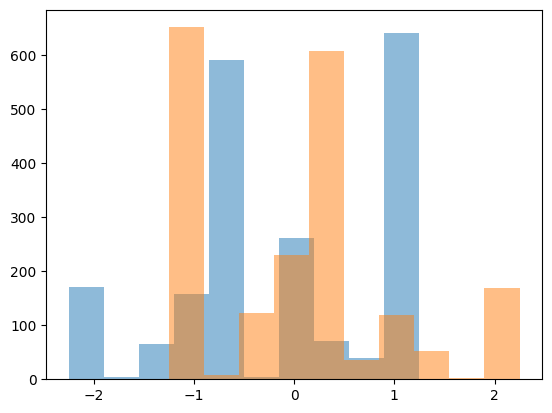

In [44]:
plt.hist(logit(data_feature.query('T == 0')['m']), alpha=0.5)
plt.hist(logit(data_feature.query('T == 1')['m']), alpha=0.5)

In [45]:
np.mean(logit(data_feature.query('T == 0')['m'])), np.mean(logit(data_feature.query('T == 1')['m']))

(-0.0522457744527572, 0.004921331105541703)

In [46]:
np.mean((data_feature.query('T == 0')['m'])), np.mean((data_feature.query('T == 1')['m']))

(0.49357448404452237, 0.4958839000949628)

(array([ 982.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1013.]),
 array([-0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
         0.2 ,  0.25]),
 <BarContainer object of 10 artists>)

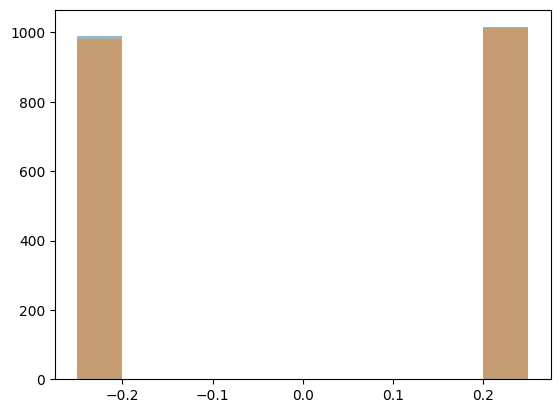

In [47]:
plt.hist(data_feature.query('T == 0')['X1_N1'], alpha=0.5)
plt.hist(data_feature.query('T == 1')['X1_N1'], alpha=0.5)

(array([168.,   2.,  53., 149.,   4., 607., 230., 123.,   8., 651.]),
 array([-0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,
         0.2 ,  0.25]),
 <BarContainer object of 10 artists>)

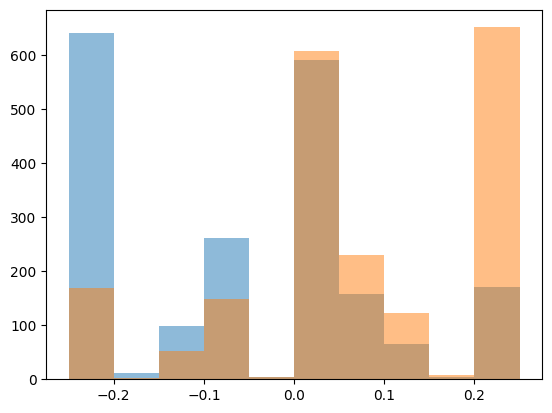

In [48]:
plt.hist(data_feature.query('T == 0')['W1_N1'], alpha=0.5)
plt.hist(data_feature.query('T == 1')['W1_N1'], alpha=0.5)

In [49]:
np.mean(data_feature.query('T == 0').iloc[:,-7:], 0)

Y        0.504239
X1_N1    0.003117
X2_N1   -0.000125
X3_N1    0.003865
W1_N1   -0.063965
W2_N1    0.002684
W3_N1    0.004559
dtype: float64

In [50]:
np.mean(data_feature.query('T == 1').iloc[:,-7:], 0)

Y        0.491228
X1_N1    0.003885
X2_N1   -0.000627
X3_N1    0.001880
W1_N1    0.070726
W2_N1    0.004474
W3_N1    0.000855
dtype: float64

In [51]:
np.mean(data_feature.query('T == 1').iloc[:,-7:], 0) - np.mean(data_feature.query('T == 0').iloc[:,-7:], 0)

Y       -0.013011
X1_N1    0.000768
X2_N1   -0.000502
X3_N1   -0.001986
W1_N1    0.134690
W2_N1    0.001791
W3_N1   -0.003704
dtype: float64